<a href="https://colab.research.google.com/github/aljebraschool/Multi_Layer_perceptron/blob/main/mnist_mlp_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Layer Perceptron, MNIST
---
In this notebook, we will train an MLP to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database.

The process will be broken down into the following steps:
>1. Load and visualize the data
2. Define a neural network
3. Train the model
4. Evaluate the performance of our trained model on a test dataset!

Before we begin, we have to import the necessary libraries for working with data and PyTorch.

In [ ]:
# import libraries
import torch
import numpy as np

---
## Load and Visualize the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a few moments, and you should see your progress as the data is loading. You may also choose to change the `batch_size` if you want to load more data at a time.

This cell will create DataLoaders for each of our datasets.

In [ ]:
# The MNIST datasets are hosted on yann.lecun.com that has moved under CloudFlare protection
# Run this script to enable the datasets download
# Reference: https://github.com/pytorch/vision/issues/1938

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [ ]:
from torchvision import datasets
from torch.utils.data.dataset import random_split
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

#creating a % of train split
train_size = int(0.8 * len(train_data))

#creating a validation split from train data
validation_size = len(train_data) - train_size

#created a new dataset based on the split above
train_dataset, validation_dataset = random_split(train_data, [train_size, validation_size])

# now load the train dataset with the new train dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= batch_size, shuffle = True)

# now load the validation dataset
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size)

#then the test data is being loader here
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)

100%|██████████| 9912422/9912422 [00:00<00:00, 99002989.08it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 98886280.67it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28716066.87it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21405088.50it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



### Visualize a Batch of Training Data

The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

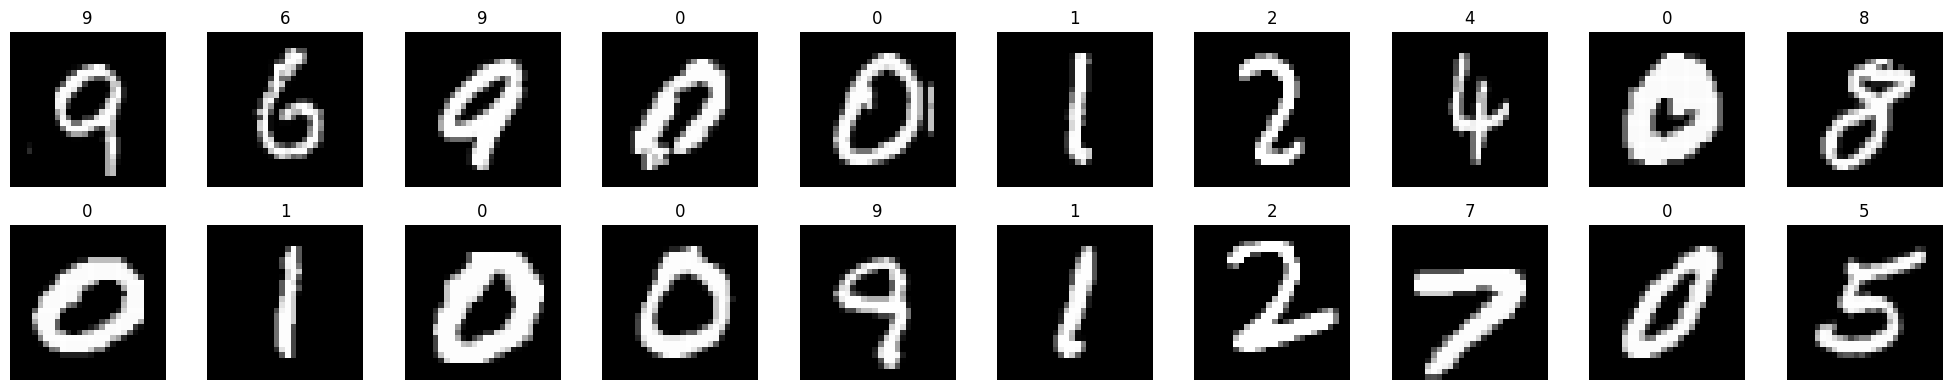

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# obtain one batch of training images
dataiter = next(iter(train_loader))
images, labels = dataiter

#convert images to numpy array and remove any unit dimension (1)
images = images.numpy().squeeze()


#create figure and subplot in that figure using the dimensions below
fig, axes = plt.subplots(figsize = (20, 4), nrows = 2,  ncols=10)

#enumerate through axes subplot
for index, ax in enumerate(axes.flat):

  #append each subplot in the figure using the imshow function of maplotlib
  ax.imshow(images[index], cmap = 'gray')

  #set the title of the image
  ax.set_title(str(labels[index].item()))

  #remove xticks, yticks, xticklabels and yticklabels
  ax.axis('off')

  #give appropriate space within each subplot
  plt.tight_layout()



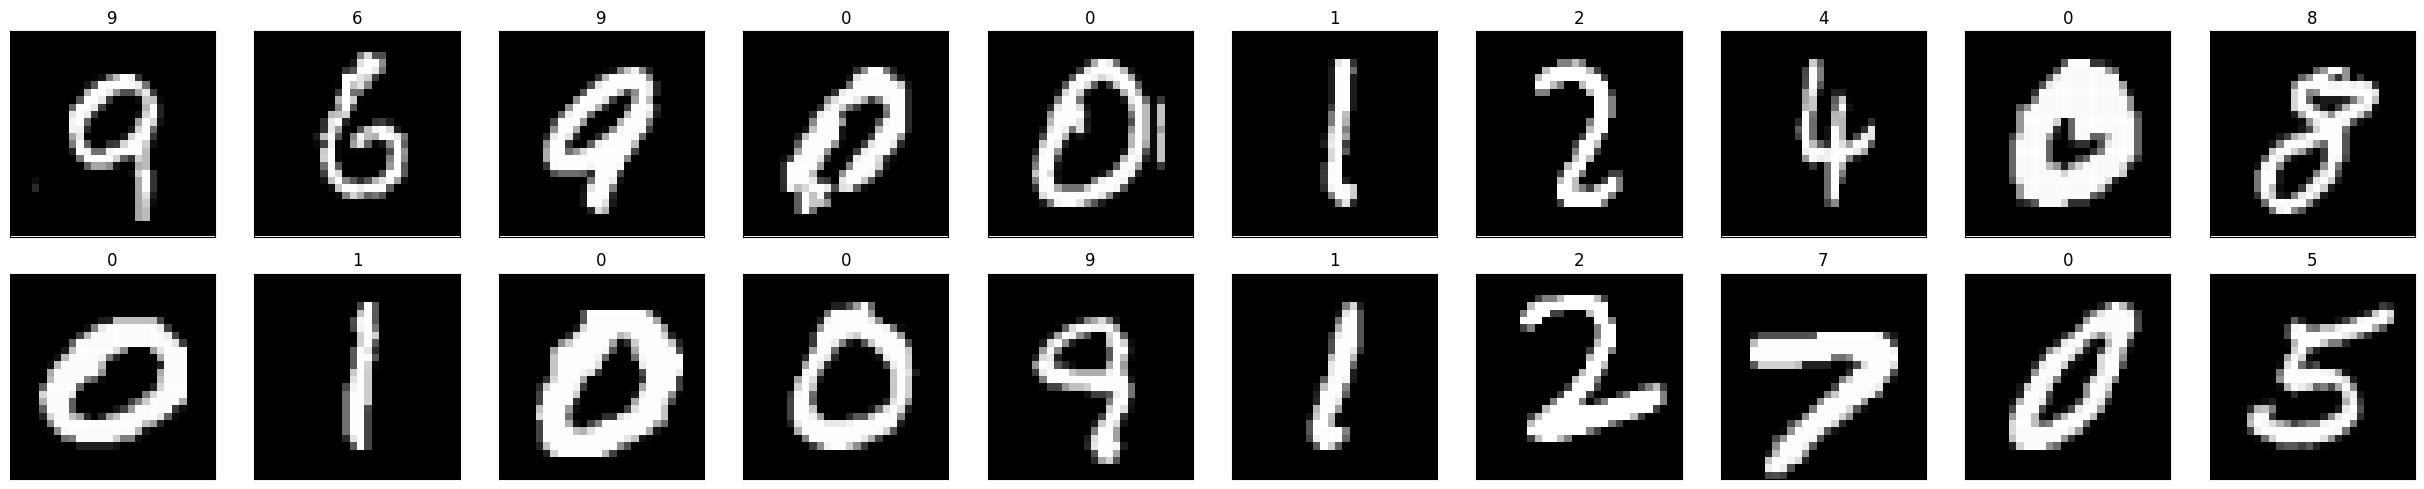

In [ ]:
#another method for implementing the same problem above

fig = plt.figure(figsize = (25, 5))   #create a figure

#loop through an array of images (20 in this case)
for index in np.arange(20):

  #add subplot to the figure created above, 2 rows, 10 cols, remove xticks and yticks
  ax = fig.add_subplot(2, 10, index + 1, xticks = [], yticks = [])

  #use imshow to display the image
  ax.imshow(images[index], cmap = 'gray')

  #set the title using the labels
  ax.set_title(str(labels[index].item()))

  #give appropriate space within each subplot
  plt.tight_layout()



### View an Image in More Detail

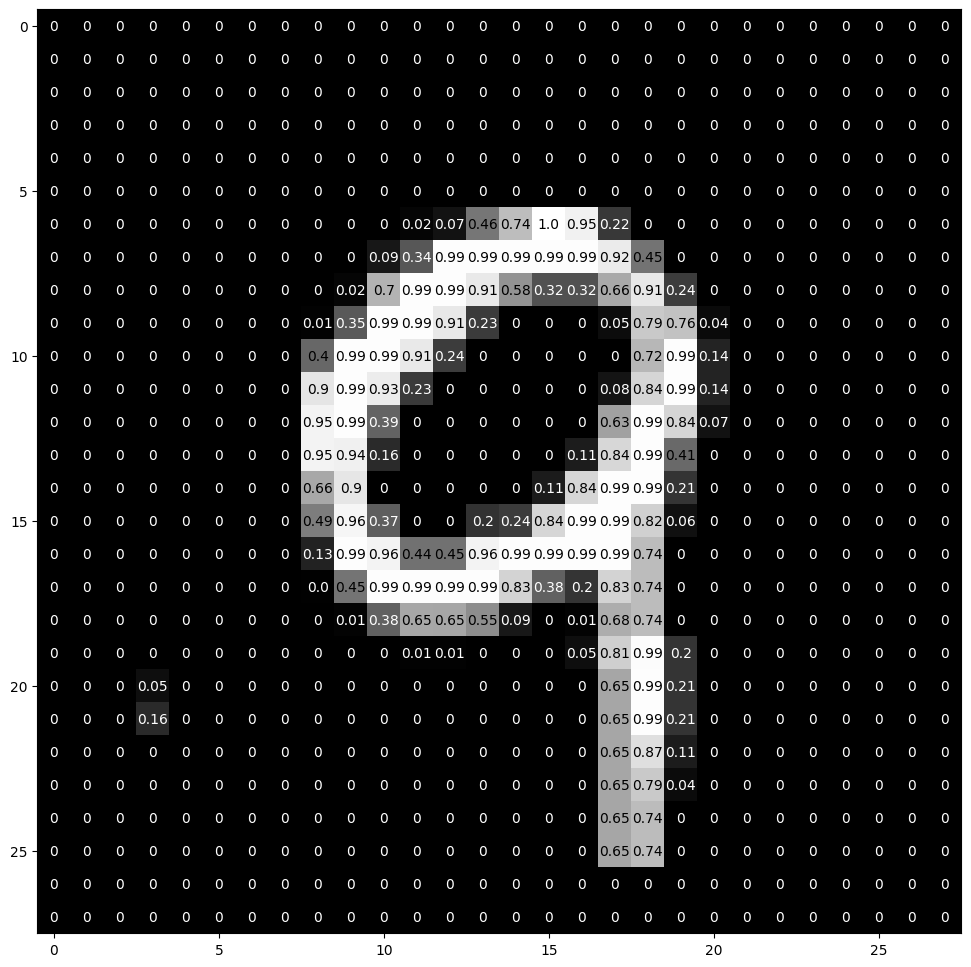

In [ ]:
#pass the first image to the squeeze method to remove unit dimension
img = np.squeeze(images[0])

#plot this image using these configuration
fig, ax = plt.subplots(figsize = (12, 12), nrows = 1, ncols = 1)

#show the image
ax.imshow(img, cmap = 'gray')

#unpack the image in its width and height
width, height = img.shape

#define a threshold for color to be used in the image
threshold = img.max() / 2.5

#loop throught the width
for x in range(width):

  #loop through the column
  for y in range(height):

    #assign a round up value to a pixel in the image
    value = round(img[x][y], 2) if img[x][y] !=0 else 0

    #use anotate to put the values on every position of the pixel in the image based on color
    ax.annotate(str(value), xy = (y, x), horizontalalignment = 'center',
                verticalalignment = 'center', color = 'white' if img[x][y] < threshold else 'black' )




---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

The architecture will be responsible for seeing as input a 784-dim Tensor of pixel values for each image, and producing a Tensor of length 10 (our number of classes) that indicates the class scores for an input image. This particular example uses two hidden layers and dropout to avoid overfitting.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

## TODO: Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # linear layer (784 -> 1 hidden node)
        #creating the layers of the network
        self.first_layer = nn.Linear(784, 200)
        self.second_layer = nn.Linear(200, 100)
        self.output_layer = nn.Linear(100, 10)

        self.dropout = nn.Dropout(p = 0.2)


    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        x = self.dropout(F.relu(self.first_layer(x)))
        x = self.dropout(F.relu(self.second_layer(x)))
        x = F.log_softmax(self.output_layer(x), dim=1)
        # add hidden layer, with relu activation function
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (first_layer): Linear(in_features=784, out_features=200, bias=True)
  (second_layer): Linear(in_features=200, out_features=100, bias=True)
  (output_layer): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


###  Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

It's recommended that you use cross-entropy loss for classification. If you look at the documentation (linked above), you can see that PyTorch's cross entropy function applies a softmax funtion to the output layer *and* then calculates the log loss.

In [ ]:
## TODO: Specify loss and optimization functions
from torch import optim
# specify loss function
criterion = nn.NLLLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.01)

---
## Train the Network

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

The following loop trains for 30 epochs; feel free to change this number. For now, we suggest somewhere between 20-50 epochs. As you train, take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data.

In [ ]:
# number of epochs to train the model
epochs = 50 # suggest training between 20-50 epochs

#best validation loss so far
best_validation_loss = float('inf')

#early stopping when loss is not changing
early_patience_stopping = 10

#keep track of the validation loss is < previous validation loss
patience_counter = 0


model.train() # prep model for training

train_losses, validation_losses = [], []
for e in range(epochs):
    # monitor training loss
    train_loss = 0

    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()

    else:
      validation_loss = 0
      model.eval()
      with torch.no_grad():
        for images, labels in validation_loader:
          log_ps = model(images)
          loss = criterion(log_ps, labels)
          validation_loss += loss.item()


      model.train()
      #average of all loss accross the whole validation dataset
      validation_loss = validation_loss/len(validation_loader)

      ## implementing early stopping algorithm ##

      #compare the present accumulated loss in the epoch with the best loss set before entering this loop
      if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')

      #if false, increase the patience counter then compare it with early stopping and break out of the loop
      else:
        patience_counter += 1
        if patience_counter >= early_patience_stopping:
          print(f'Early stopping at {e}')
          break

    # print training statistics
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader)

    #put the average of every epoch loss in a list
    train_losses.append(train_loss)
    validation_losses.append(validation_loss)


    print(f'Epoch: {e+1}/{epochs}...'
          f'Train Loss: {train_loss:>5.3f}...'
          f'Validation Loss: {validation_loss:>5.3f}...'
          )




Epoch: 1/50...Train Loss: 0.494...Validation Loss: 0.265...
Epoch: 2/50...Train Loss: 0.387...Validation Loss: 0.282...
Epoch: 3/50...Train Loss: 0.380...Validation Loss: 0.311...
Epoch: 4/50...Train Loss: 0.362...Validation Loss: 0.303...
Epoch: 5/50...Train Loss: 0.352...Validation Loss: 0.270...
Epoch: 6/50...Train Loss: 0.344...Validation Loss: 0.310...
Epoch: 7/50...Train Loss: 0.329...Validation Loss: 0.268...
Epoch: 8/50...Train Loss: 0.331...Validation Loss: 0.281...
Epoch: 9/50...Train Loss: 0.322...Validation Loss: 0.267...
Epoch: 10/50...Train Loss: 0.318...Validation Loss: 0.325...
Early stopping at 10


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

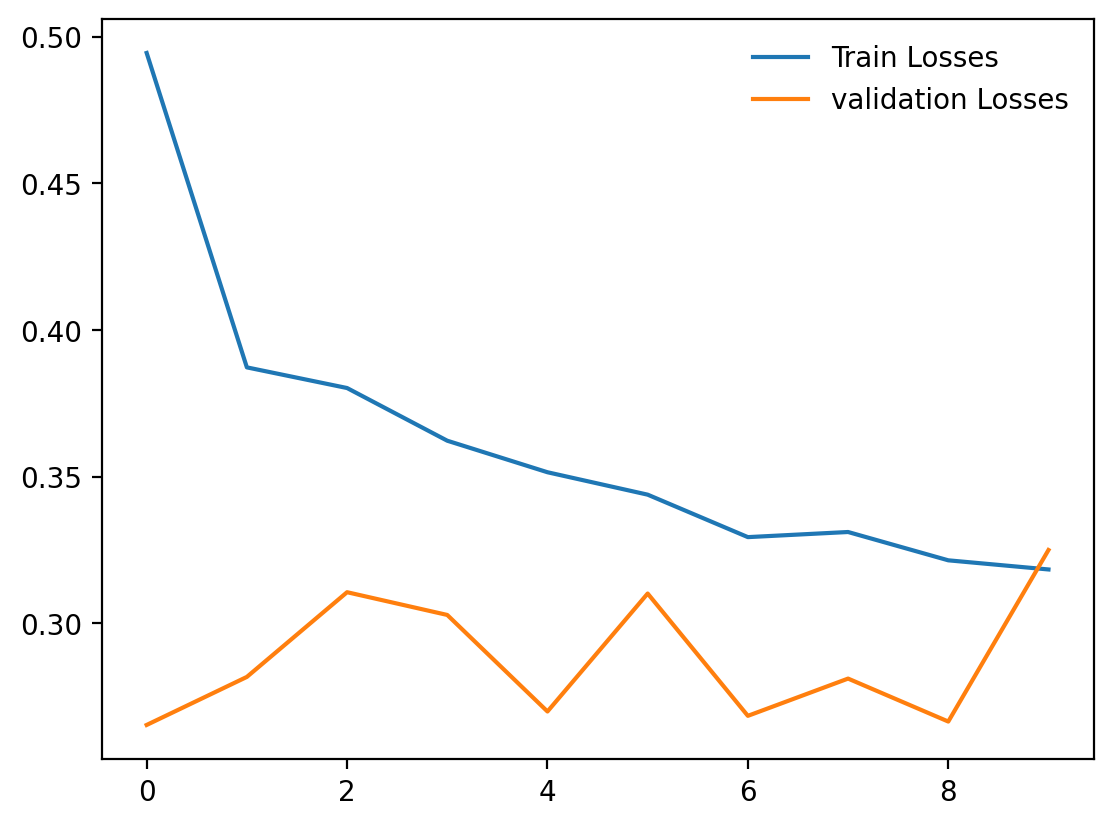

In [ ]:
plt.plot(train_losses, label = "Train Losses")
plt.plot(validation_losses, label = "validation Losses")
plt.legend(frameon=False)

In [ ]:
# #this line loads the saved model state dictionaries
# state_dict = torch.load('best_model.pth')

# #this code loads it in our model with the same architecture for use
# model.load_state_dict(state_dict)
model.load_state_dict(torch.load('best_model.pth'))

model.state_dict().keys()

odict_keys(['first_layer.weight', 'first_layer.bias', 'second_layer.weight', 'second_layer.bias', 'output_layer.weight', 'output_layer.bias'])

---
## Test the Trained Network

Finally, we test our best model on previously unseen **test data** and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

#### `model.eval()`

`model.eval(`) will set all the layers in your model to evaluation mode. This affects layers like dropout layers that turn "off" nodes during training with some probability, but should allow every node to be "on" for evaluation!

In [ ]:
# # using the saved model to evaluate its performance on new set of data

# accuracy = 0
# test_set_loss = 0

# with torch.no_grad():
#         model.eval()
#         for images, labels in test_loader:
#           log_ps = model(images)
#           loss = criterion(log_ps, labels)
#           test_set_loss += loss.item()

#           ps = torch.exp(log_ps)
#           top_p, top_class = ps.topk(1, dim = 1)
#           equals = top_class == labels.view(*top_class.shape)
#           accuracy += torch.mean(equals.type(torch.FloatTensor))

# model.train()
#       #train_loss = train_set_loss/len(train_loader)
# test_loss = test_set_loss/len(test_loader)

# print("Test Loss: {:>5.3f}.. ".format(test_loss),
#         "Accuracy: {:>5.3f}.. ".format(accuracy / len(test_loader)))



# Evaluate the model on the test set


epochs = 10
for e in range(epochs):
  accuracy = 0
  test_set_loss = 0
  with torch.no_grad():
    model.eval()
    for images, labels in test_loader:
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        test_set_loss += loss.item()

        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))

  # Calculate average test loss and accuracy
  test_loss = test_set_loss / len(test_loader)
  accuracy /= len(test_loader)

  print("Test Loss: {:>5.3f}.. ".format(test_loss),
        "Accuracy: {:>5.3f}%.. ".format(accuracy.item() * 100))




Test Loss: 0.264..  Accuracy: 92.700%.. 
Test Loss: 0.264..  Accuracy: 92.700%.. 
Test Loss: 0.264..  Accuracy: 92.700%.. 
Test Loss: 0.264..  Accuracy: 92.700%.. 
Test Loss: 0.264..  Accuracy: 92.700%.. 
Test Loss: 0.264..  Accuracy: 92.700%.. 
Test Loss: 0.264..  Accuracy: 92.700%.. 
Test Loss: 0.264..  Accuracy: 92.700%.. 
Test Loss: 0.264..  Accuracy: 92.700%.. 
Test Loss: 0.264..  Accuracy: 92.700%.. 


### Visualize Sample Test Results

This cell displays test images and their labels in this format: `predicted (ground-truth)`. The text will be green for accurately classified examples and red for incorrect predictions.

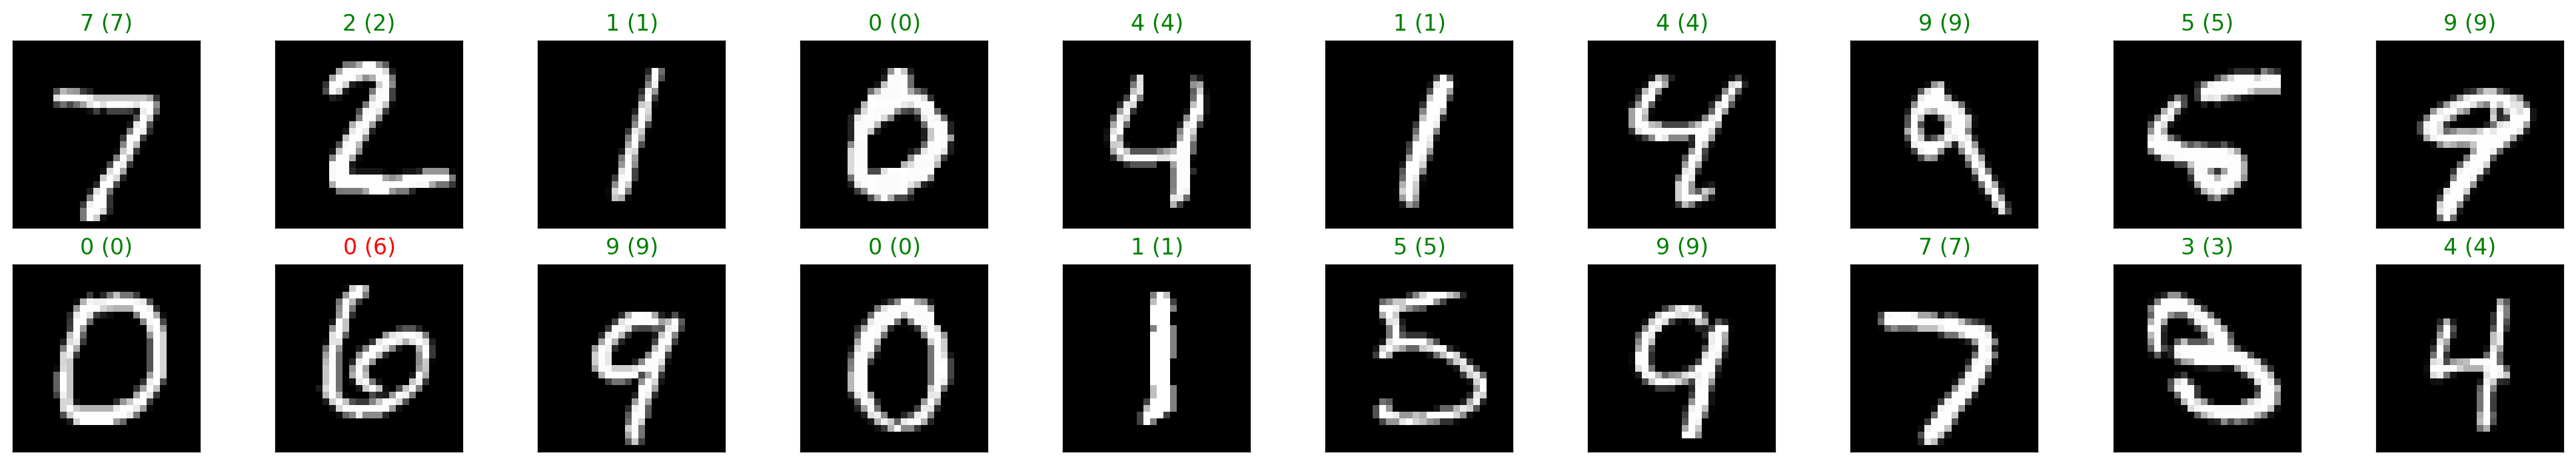

In [ ]:
# obtain one batch of test images
dataiter = next(iter(test_loader))
images, labels = dataiter

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

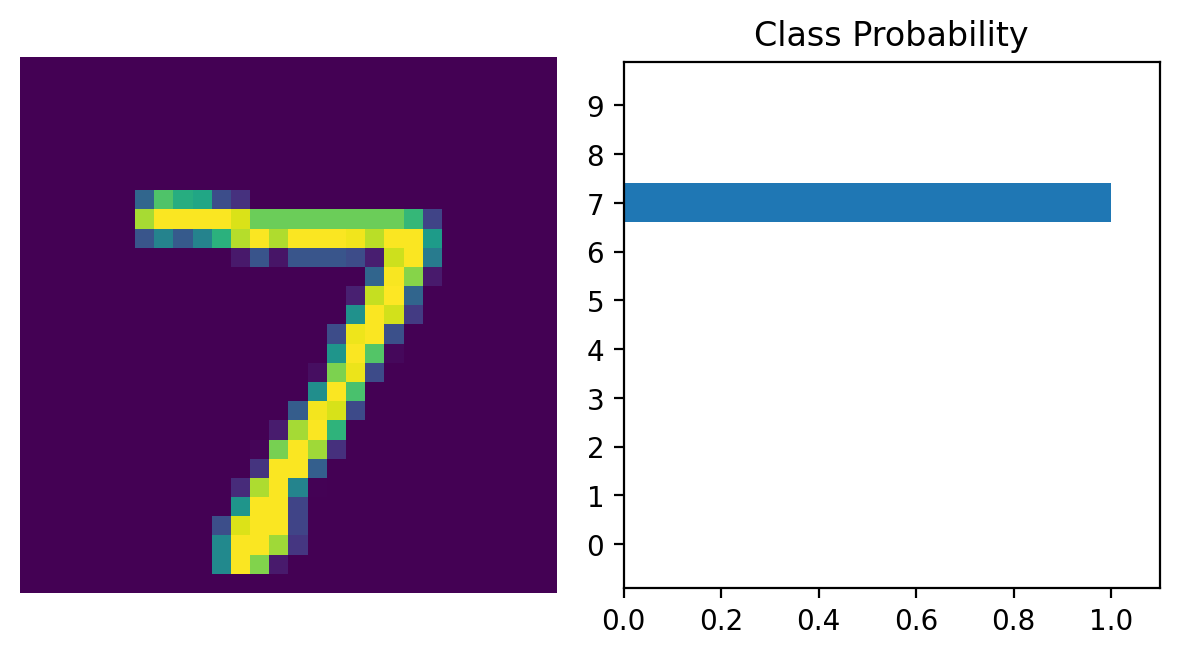

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)

# Obtain one batch of test images
images, labels = next(dataiter)

img = images[0].view(1, -1)

# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)


ps = ps.data.numpy().squeeze()

fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
ax1.axis('off')
ax2.barh(np.arange(10), ps)
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)

plt.tight_layout()

